# NoBadComments - Comment Toxicity Classification using PyTorch

Yes, it's exactly what the title says. There's toxic comments. There's PyTorch. There's NLP and deep learning. Much fun, such wow.

---

## 1. Getting Started

First things first, let's import all of the necessary dependencies for this project.

In [1]:
# General imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# Torchtext imports
import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# Disable `torchtext` deprecation warning
torchtext.disable_torchtext_deprecation_warning()

/home/ravindu-aratchige/Documents/Machine Learning/pytorch-crash-course/env/lib/python3.12/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/ravindu-aratchige/Documents/Machine Learning/pytorch-crash-course/env/lib/python3.12/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/ravindu-aratc

Next, we can load the training data from the `data/train.csv` file provided as part of the complete dataset.

In [2]:
# Load data from CSV file into Pandas dataframe
df = pd.read_csv("./data/train.csv")

df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Here, we can see that the dataset contains the following columns:

1. `id` - unique identifier for each sample in the dataset.
2. `comment_text` - the text content of each comment.
3. `toxic` - whether the comment is toxic (1) or not (0).
4. `severe_toxic` - whether the comment is toxic (1) or not (0).
5. `obscene` - whether the comment is obscene (1) or not (0).
6. `threat` - whether the comment includes a threat (1) or not (0).
7. `insult` - whether the comment includes an insult (1) or not (0).
8. `identity_hate` - whether the comment includes identity hate such as racism (1) or not (0).

Thus, it appears we have a **multiclass classification** problem.

---

## 2. Exploratory Data Analysis

We can begin EDA by inspecting the dataset for how much data it contains, as well as whether any columns contain missing values, using `df.info()`.

In [3]:
# Get overview of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


We can also retrieve a statistical summary of each column of the dataset (e.g. mean, standard deviation etc.) using `df.describe()`. 

In [4]:
# Get statistical summary of data
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We can also visualize how much data in each target variable column belongs to either `0` or `1`.

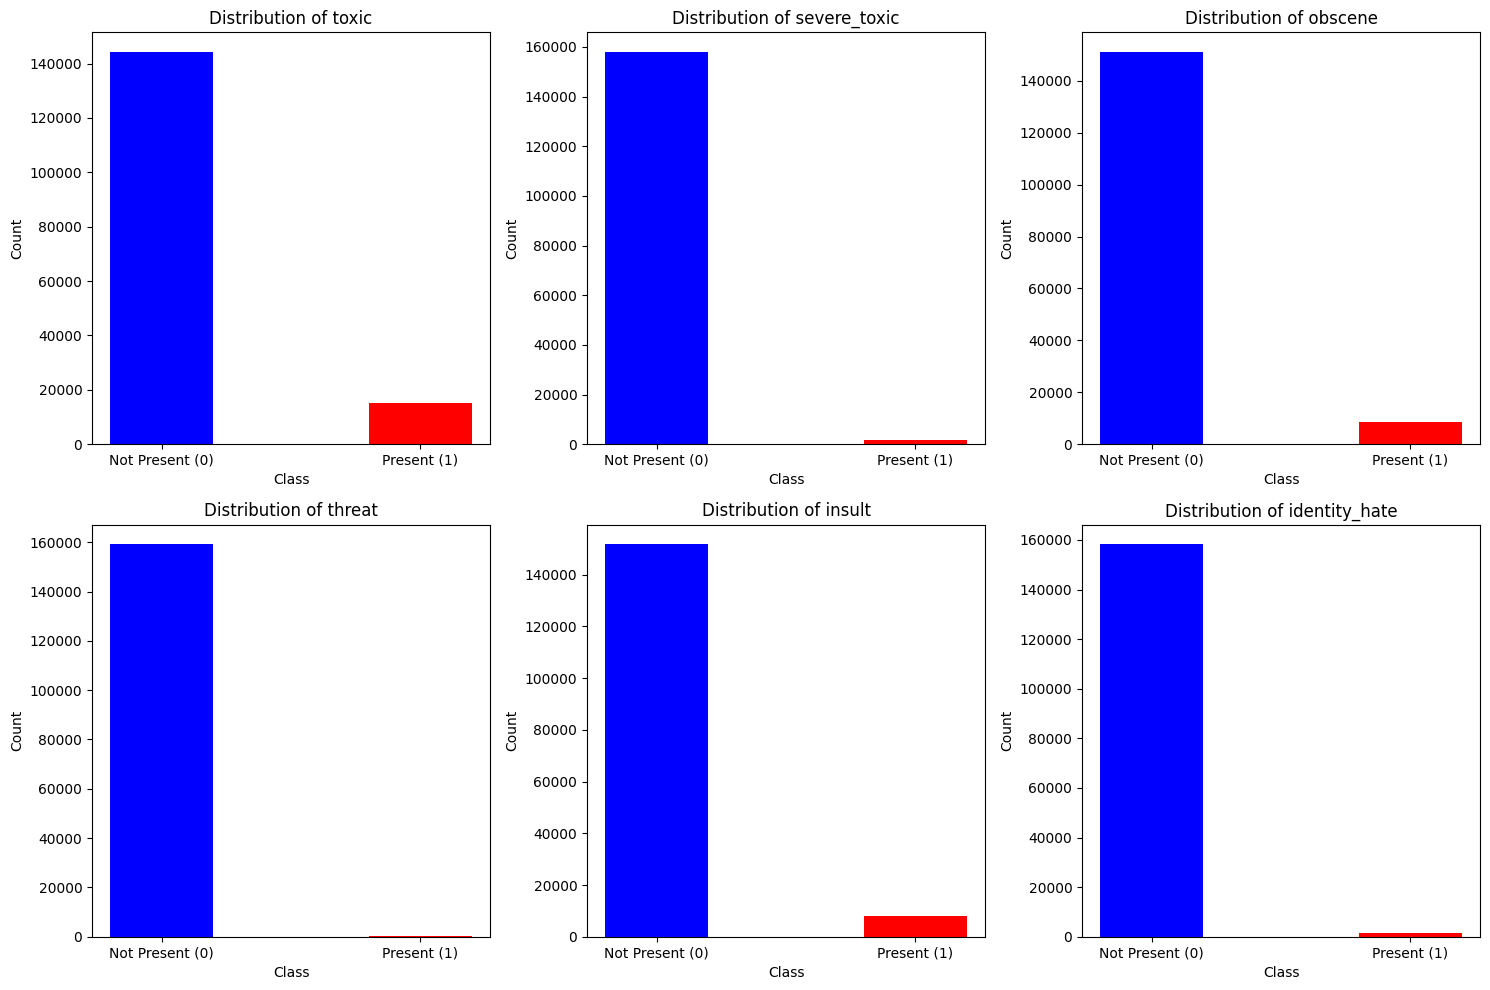

In [5]:
# Select the target columns
target_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Count occurrences of 0s and 1s
counts = {col: df[col].value_counts().sort_index() for col in target_cols}

# Plot bar charts
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Arrange in 2 rows, 3 columns
axes = axes.flatten()  # Flatten for easy looping

for i, col in enumerate(target_cols):
    axes[i].bar(counts[col].index, counts[col].values, color=['blue', 'red'], width=0.4)
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(["Not Present (0)", "Present (1)"])
    axes[i].set_ylabel("Count")
    axes[i].set_xlabel("Class")

# Adjust layout for better spacing
plt.tight_layout()

plt.show()

---

## 3. Data Preprocessing

Here, we will follow a simple but effective data preprocessing pipeline, which includes the following steps:

1. Creating a vocabulary using `torchtext`.
2. Splitting data for training and validation.
3. Defining the data loaders for training and validation.

---

### The Tokenizer

We start by instantiating a **tokenizer** using `get_tokenizer` from `torchtext.data.utils`

In [6]:
# Initialize tokenizer
tokenizer = get_tokenizer("basic_english")

We can test this tokenizer out by passing a sample comment from the dataset through it.

In [7]:
# Get comment text content of first sample in dataset
sample_comment = df["comment_text"].values[0]
print(f"Sample comment before tokenization: {sample_comment}\n\n")

# Get tokens for sample comment
sample_comment_tokenized = tokenizer(sample_comment)
print(f"Sample comment after tokenization: {sample_comment_tokenized}")

Sample comment before tokenization: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


Sample comment after tokenization: ['explanation', 'why', 'the', 'edits', 'made', 'under', 'my', 'username', 'hardcore', 'metallica', 'fan', 'were', 'reverted', '?', 'they', 'weren', "'", 't', 'vandalisms', ',', 'just', 'closure', 'on', 'some', 'gas', 'after', 'i', 'voted', 'at', 'new', 'york', 'dolls', 'fac', '.', 'and', 'please', 'don', "'", 't', 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', 'i', "'", 'm', 'retired', 'now', '.', '89', '.', '205', '.', '38', '.', '27']


---

### Creating The Vocabulary

We can create a vocabulary of words using `build_vocab_from_iterator()` from `torchtext.vocab`. For this, we have to define:

1. The vocabulary's size (the number of words in the vocabulary)
2. The unknown token
3. The padding token

In [8]:
# Define vocabulary size
VOCAB_SIZE = 1500

# Define unknown token and padding token
unk_token = "<unk>"
pad_token = "<pad>"

Now, we can build the vocabulary after converting all of the comments in the dataset into tokens.

In [9]:
# Tokenize all comments in the dataset
comment_tokens = df["comment_text"].map(tokenizer)

print(f"Preview of comment tokens: \n{comment_tokens.head()}\n\n")

# Build vocabulary from tokenized comments
vocab = build_vocab_from_iterator(
    iterator=comment_tokens,
    specials=[unk_token, pad_token],
    max_tokens=VOCAB_SIZE,
)

# Inspect location of a sample word in the vocabulary
print(f"Location of the word 'experience' in the vocabulary: {vocab["experience"]}")

# Inspect location of the unknown token and padding token in the vocabulary
print(f"Location of the unknown token in the vocabulary: {vocab[unk_token]}")
print(f"Location of the padding token in the vocabulary: {vocab[pad_token]}")

Preview of comment tokens: 
0    [explanation, why, the, edits, made, under, my...
1    [d, ', aww, !, he, matches, this, background, ...
2    [hey, man, ,, i, ', m, really, not, trying, to...
3    [more, i, can, ', t, make, any, real, suggesti...
4    [you, ,, sir, ,, are, my, hero, ., any, chance...
Name: comment_text, dtype: object


Location of the word 'experience' in the vocabulary: 1078
Location of the unknown token in the vocabulary: 0
Location of the padding token in the vocabulary: 1


We must also set the default token for unknown words that are not part of the vocabulary as `unk_token`.

In [10]:
# Set default token for unknown words
vocab.set_default_index(vocab[unk_token])

# Test with sample unknown word
vocab["aratchige"]

0

We can now confirm that the vocabulary works as intended via an example. Here, we will retrieve the indices for some tokens from the vocabulary, and then use these indices to query the vocabulary and see if the same tokens are retrieved.

In [11]:
# Get example tokens for testing vocabulary (first 10 words of first comment in the dataset)
example_tokens = tokenizer(df["comment_text"].values[0])[:10]
print(f"Tokens considered for example: {example_tokens}")

# Fetch indices of above example tokens
example_indices = vocab.lookup_indices(example_tokens)
print(f"Indices of example tokens: {example_indices}")

# Retrieve tokens from vocab based on above fetched indices
example_tokens_from_indices = vocab.lookup_tokens(example_indices)
print(f"Tokens retrieved from fetched indices: {example_tokens_from_indices}")

Tokens considered for example: ['explanation', 'why', 'the', 'edits', 'made', 'under', 'my', 'username', 'hardcore', 'metallica']
Indices of example tokens: [667, 85, 3, 140, 142, 185, 39, 663, 0, 0]
Tokens retrieved from fetched indices: ['explanation', 'why', 'the', 'edits', 'made', 'under', 'my', 'username', '<unk>', '<unk>']


Here, we can see that, apart from a few tokens such as `hardcore` and `metallica` (which may have been excluded due to the small `VOCAB_SIZE` of `1500`), the rest of the tokens can be successfully fetched from the vocabulary.

---

### Creating the Datasets

In this step, we will create the training, validation and testing datasets needed to train and evaluate the deep learning model.

Before this, we must perform a crucial preprocessing step on the comments in the dataset - truncating unnecessarily long comments and adding padding tokens to sentences that are too short. We can write a helper function for this as given below.

Before this, we must perform a crucial preprocessing step on the comments in the dataset - truncating unnecessarily long comments and adding padding tokens to sentences that are too short. We can write a helper function for this as given below.

In [12]:
# Define function to truncate and process comments (for creating datasets)
def process_tokenized_comments(tokens):
    if len(tokens) > MAX_LENGTH:
        # Truncate comment
        return tokens[:MAX_LENGTH]
    else:
        # Pad comment
        return tokens + ([pad_token] * (MAX_LENGTH - len(tokens)))

We can inspect whether this helper function works as intended via an example.

In [13]:
# Example usage of helper function

# Set example max length for sentences
MAX_LENGTH = 5

# Truncation example
comment_to_truncate = "This is a random comment I felt like writing for you."
print(f"Example comment before truncation: {comment_to_truncate}")
truncated_comment = process_tokenized_comments(tokenizer(comment_to_truncate))
print(f"Truncated example comment: {truncated_comment}\n")

# Padding example
comment_to_pad = "What ya doin"
print(f"Example comment before padding: {comment_to_pad}")
padded_comment = process_tokenized_comments(tokenizer(comment_to_pad))
print(f"Padded example comment: {padded_comment}")

Example comment before truncation: This is a random comment I felt like writing for you.
Truncated example comment: ['this', 'is', 'a', 'random', 'comment']

Example comment before padding: What ya doin
Padded example comment: ['what', 'ya', 'doin', '<pad>', '<pad>']


To determine a reasonable comment length for processing as such, we can inspect the distribution of the lengths of the comments in the dataset. Here, we will select 1000 random comments from the data, as the entire dataset is too large for inspection.

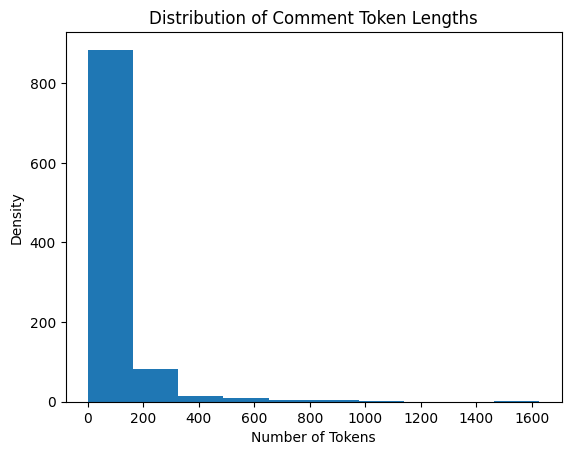

In [14]:
# Get random sample of 1000 comments from the data
sample_comments = df["comment_text"].sample(1000)

# Tokenize retrieved sample of comments, and get lengths of each tokenized comments
tokenized_comments = sample_comments.map(tokenizer)
token_lengths = tokenized_comments.map(len)

plt.hist(token_lengths)
plt.title('Distribution of Comment Token Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Density')
plt.show()

Here, we can see that the majority of the comments are less than 400 tokens, so we will set the `MAX_LENGTH` of sentences as `400`. Anything shorter wil be padded, and anything longer will be truncated.

In [15]:
# Set max length for sentences
MAX_LENGTH = 150

To create separate datasets for training and validation, we must create a custom **Dataset class** which subclasses `torch.utils.data.Dataset`. This custom dataset class must implement the `__init__()`, `__getitem__()` and `__len__()` methods from the base class (see [PyTorch docs](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)).

In [16]:
# Custom dataset class
class ToxicCommentDataset(Dataset):
    def __init__(self, df, testing=False):
        super().__init__()
        self.df = df
        self.testing = testing

    def __getitem__(self, idx):
        # Get text of relevant comment from dataframe
        text = self.df["comment_text"].values[idx]

        # Get tokens for retrieved comment's text
        tokens = process_tokenized_comments(tokenizer(text))

        input_ = torch.tensor(vocab.lookup_indices(tokens))

        if self.testing:
            target = torch.zeros(6).float()
        else:
            target = torch.tensor(self.df[target_cols].values[idx]).float()

        return input_, target

    def __len__(self):
        return len(self.df)

# Initialize dataset
dataset = ToxicCommentDataset(df)
dataset[0]

(tensor([ 667,   85,    3,  140,  142,  185,   39,  663,    0,    0, 1287,   96,
          329,   27,   57,    0,    9,   31,    0,    4,   61,    0,   21,   71,
            0,  158,    6,    0,   45,  130, 1167,    0,    0,    2,    8,   55,
           70,    9,   31,  253,    3,  369,   41,    3,   50,   38,  155,    6,
            9,   81,    0,   99,    2,    0,    2,    0,    2,    0,    2, 1122,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,  

Next, we can split this dataset for **training** and **validation** separately using the `random_split()` method from `torch.utils.data`. We will use an **80/20** split here.

In [17]:
# Set dataset split ratio (80% for training)
training_data_ratio = 0.8

# Split dataset for training and validation
train_dataset, val_dataset = random_split(dataset, [training_data_ratio, (1 - training_data_ratio)])

In the meantime, we can also create a testing dataset, which can be used later to evaluate model performance.

In [18]:
# Load testing data from CSV file
test_df = pd.read_csv("./data/test.csv")

# Create test dataset from loaded data
test_dataset = ToxicCommentDataset(test_df, testing=True)

# Inspect a sample of the test dataset
dataset[0]

(tensor([ 667,   85,    3,  140,  142,  185,   39,  663,    0,    0, 1287,   96,
          329,   27,   57,    0,    9,   31,    0,    4,   61,    0,   21,   71,
            0,  158,    6,    0,   45,  130, 1167,    0,    0,    2,    8,   55,
           70,    9,   31,  253,    3,  369,   41,    3,   50,   38,  155,    6,
            9,   81,    0,   99,    2,    0,    2,    0,    2,    0,    2, 1122,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,  

---

### Building the Dataloaders

Here, we will define the dataloaders for training, validation and testing. We will be using a batch size of `32`.

In [27]:
# Set batch size for dataloaders
BATCH_SIZE = 64

# Define training dataloader
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# Define training dataloader
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# Define training dataloader
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
)

We can select one of the dataloaders to inspect and verify whether it has been setup correctly. Consider the training dataloader:

In [20]:
for a_input, a_target in train_dataloader:
    print(f"a_input shape: {a_input.shape}, a_target shape: {a_target.shape}")
    print(f"a_input dtype: {a_input.dtype}, a_target dtype: {a_target.dtype}")
    break

a_input shape: torch.Size([32, 150]), a_target shape: torch.Size([32, 6])
a_input dtype: torch.int64, a_target dtype: torch.float32


---

## 4. Model Building

For this task, we will be building and training an **RNN** (**Recurrent Neural Network**). More specifically, we will be building a special type of RNN known as an **LSTM** (**Long Short Term Memory**) model.

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class ToxicCommentClassifier(nn.Module):
    def __init__(self, vocab_size=1500):
        super(ToxicCommentClassifier, self).__init__()
        self.emb = nn.Embedding(vocab_size, 256, padding_idx=1)
        self.lstm = nn.LSTM(256, 128, 1, batch_first=True)
        self.fc1 = nn.Linear(128, 6)  # 6 output classes (multi-class classification)

    def forward(self, x):
        out = self.emb(x)  # Embedding lookup
        out, (hn, cn) = self.lstm(out)  # LSTM output
        out = F.relu(out[:, -1, :])  # Get the last hidden state (-1)
        out = self.fc1(out)  # Linear layer for classification
        return out

In [34]:
# Hyperparameters
EPOCHS = 10
LEARNING_RATE = 0.01
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize model, loss function, and optimizer
model = ToxicCommentClassifier(vocab_size=1500).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()  # Suitable for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [28]:
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()  # Set model to training mode
    total_loss = 0

    for batch in train_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()

    return total_loss / len(train_loader)  # Average loss per batch

In [24]:
def validate_model(model, val_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0

    with torch.no_grad():  # No gradient calculations
        for batch in val_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item()

    return total_loss / len(val_loader)  # Average loss

In [29]:
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} started...")
    train_loss = train_model(model, train_dataloader, optimizer, criterion, DEVICE)
    val_loss = validate_model(model, val_dataloader, criterion, DEVICE)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1 started...
Epoch 1/10, Train Loss: 0.0996, Val Loss: 0.0792
Epoch 2 started...
Epoch 2/10, Train Loss: 0.0780, Val Loss: 0.0722
Epoch 3 started...
Epoch 3/10, Train Loss: 0.0737, Val Loss: 0.0678
Epoch 4 started...
Epoch 4/10, Train Loss: 0.0683, Val Loss: 0.0681
Epoch 5 started...
Epoch 5/10, Train Loss: 0.0673, Val Loss: 0.0638
Epoch 6 started...
Epoch 6/10, Train Loss: 0.0676, Val Loss: 0.0670
Epoch 7 started...
Epoch 7/10, Train Loss: 0.0676, Val Loss: 0.0633
Epoch 8 started...
Epoch 8/10, Train Loss: 0.0665, Val Loss: 0.0651
Epoch 9 started...
Epoch 9/10, Train Loss: 0.0667, Val Loss: 0.0731
Epoch 10 started...
Epoch 10/10, Train Loss: 0.0717, Val Loss: 0.0672


After training, we can save the model as a `.pth` file.

In [30]:
# Save model
torch.save(model.state_dict(), "model.pth")

In [36]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()  # Ensure model is in evaluation mode
    total_loss = 0.0
    all_targets = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)  # Apply sigmoid activation
            
            loss = criterion(probs, targets)
            total_loss += loss.item()

            all_targets.append(targets.cpu().numpy())
            all_predictions.append(probs.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.4f}")

    return all_targets, all_predictions

# Run evaluation
all_targets, all_predictions = evaluate_model(model, test_dataloader, F.binary_cross_entropy, DEVICE)

Test Loss: 0.7009


In [38]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

# Convert lists to numpy arrays
import numpy as np
y_true = np.vstack(all_targets)  # Shape: (num_samples, 6)
y_pred = np.vstack(all_predictions)

# Convert probabilities to binary (threshold = 0.5)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Compute metrics
roc_auc = roc_auc_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary, average='macro')

print(f"Test ROC-AUC: {roc_auc:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1-Score: {f1:.4f}")

Test ROC-AUC: nan
Test Accuracy: 0.0002
Test F1-Score: 0.0000


/home/ravindu-aratchige/Documents/Machine Learning/pytorch-crash-course/env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [39]:
print(y_pred[:10])

[[0.4804929  0.521835   0.5008299  0.49781677 0.50727826 0.5125938 ]
 [0.4804929  0.521835   0.5008299  0.4978167  0.50727826 0.5125938 ]
 [0.4804929  0.521835   0.5008299  0.49781677 0.50727826 0.5125938 ]
 [0.4804929  0.521835   0.5008299  0.4978167  0.50727826 0.5125938 ]
 [0.4804929  0.521835   0.5008299  0.4978167  0.50727826 0.5125938 ]
 [0.4804929  0.521835   0.5008299  0.4978167  0.50727826 0.5125938 ]
 [0.4804929  0.521835   0.5008299  0.4978167  0.50727826 0.5125938 ]
 [0.4804929  0.521835   0.5008299  0.4978167  0.50727826 0.5125938 ]
 [0.4804929  0.521835   0.5008299  0.4978167  0.50727826 0.5125938 ]
 [0.4804929  0.521835   0.5008299  0.4978167  0.50727826 0.5125938 ]]


In [40]:
thresholds = [0.3, 0.4, 0.5, 0.6]
for t in thresholds:
    y_pred_binary = (y_pred >= t).astype(int)
    print(f"Threshold: {t}, Positive Predictions: {y_pred_binary.sum()}")

Threshold: 0.3, Positive Predictions: 918984
Threshold: 0.4, Positive Predictions: 918984
Threshold: 0.5, Positive Predictions: 608286
Threshold: 0.6, Positive Predictions: 0
